In [70]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and Merge Datasets

## Avocado Price

In [71]:
years = [2022, 2023, 2024, 2025]
price_dataframes = []
for year in years:
    price_dataframes.append(pd.read_csv(f"avocado-data/{year}-plu-total-hab-data.csv"))
df = pd.concat(price_dataframes, ignore_index=True)

In [73]:
df.dropna(subset=['Current Year Week Ending'], inplace=True)

In [74]:
df["year_week"] = df["Current Year Week Ending"].apply(lambda x: x[:4] + '-' + str(datetime.strptime(x, "%Y-%m-%d %H:%M:%S").isocalendar()[1]))

In [75]:
df.rename(columns={
    "ASP Current Year": "average_selling_price",
    "Geography": "region",
    "Current Year Week Ending": "date",
    "Type": "type",
    "Total Bulk and Bags Units": "total_sales_volume",
    "4046 Units": "4046_units",
    "4225 Units": "4225_units",
    "4770 Units": "4770_units",
    "TotalBagged Units": "total_bagged_units"
    }, inplace=True)

In [76]:
df.drop(columns=["Timeframe", "SmlBagged Units", "LrgBagged Units", "X-LrgBagged Units"], inplace=True)

## Avocado Production Volume

In [77]:
prod_volume_dataframes = []
for year in years:
  prod_volume_dataframes.append(pd.read_csv(f"avocado-data/Volume Data  Projections - Hass Avocado Board {year}.csv"))
prod_volume = pd.concat(prod_volume_dataframes, ignore_index=True)

In [78]:
prod_volume = prod_volume[prod_volume["Status"] == "Actual"]

In [79]:
prod_volume.fillna(0, inplace=True)

In [80]:
prod_volume["year_week"] = prod_volume.apply(lambda x: str(x["Year"]) + "-" + str(x["Week Number"]), axis=1)

In [81]:
prod_volume.drop(columns=["Status", "Year", "Week Number", "Week Ending"], inplace=True)

In [82]:
prod_volume.rename(columns={
    "Total Volume": "total_prod_volume",
    "California": "california_prod_volume",
    "Chile": "chile_prod_volume",
    "Mexico": "mexico_prod_volume",
    "Peru": "peru_prod_volume",
    "Colombia": "colombia_prod_volume",
    "Dominican Republic": "dominican_republic_prod_volume"
    }, inplace=True)

In [83]:
volume_cols = ['total_prod_volume', 'california_prod_volume',
               'chile_prod_volume', 'mexico_prod_volume', 'peru_prod_volume',
               'colombia_prod_volume', 'dominican_republic_prod_volume']

In [84]:
for col in volume_cols:
    prod_volume[col] = prod_volume[col].apply(lambda x: str(x).replace(",", ""))
    prod_volume[col] = prod_volume[col].astype(float)

In [85]:
df = df.merge(prod_volume, on="year_week", how="left")

## Weekly Economic Index

The WEI is an index of real economic activity using timely and relevant high-frequency data. It represents the common component of ten different daily and weekly series covering consumer behavior, the labor market, and production. The WEI is scaled to the four-quarter GDP growth rate; for example, if the WEI reads -2 percent and the current level of the WEI persists for an entire quarter, one would expect, on average, GDP that quarter to be 2 percent lower than a year previously.

The data can be downloaded from this website: https://fred.stlouisfed.org/series/WEI

In [86]:
wei = pd.read_csv("avocado-data/WEI.csv")

In [87]:
wei["year_week"] = wei["observation_date"].apply(lambda x: x[:4] + '-' + str(datetime.strptime(x, "%Y-%m-%d").isocalendar()[1]))

In [88]:
df = df.merge(wei[['WEI', 'year_week']], on="year_week", how="left")

## Fuel Price

US weekly gasoline data can be downloaded from this website: https://www.eia.gov/petroleum/gasdiesel/

In [89]:
fuel_price = pd.read_csv("avocado-data/gasoline_price.csv")

In [90]:
fuel_price["year_week"] = fuel_price["Date"].apply(lambda x: x[:4] + '-' + str(datetime.strptime(x, "%Y-%m-%d").isocalendar()[1]))

In [91]:
df = df.merge(fuel_price[["year_week", "gasoline_price"]], on="year_week", how="left")

## US Public Holiday

In [92]:
df_holiday = pd.read_csv("avocado-data/us_holidays.csv")

In [93]:
df_holiday["year_week"] = df_holiday["A_DATE"].apply(lambda x: x[-4:] + '-' + str(datetime.strptime(x, "%m/%d/%Y").isocalendar()[1]))

In [94]:
df_holiday.rename(columns={"IS_HOLIDAY": "is_holiday"}, inplace=True)

In [95]:
df_holiday = df_holiday[df_holiday["is_holiday"] == 1]

In [96]:
df = df.merge(df_holiday[["year_week", "is_holiday"]], on="year_week", how="left")

In [97]:
df.fillna({"is_holiday": 0}, inplace=True)

# Exploratory Data Analysis

## Numerical variable distributions

In [98]:
num_cols = ['average_selling_price', 'total_sales_volume', '4046_units',
            '4225_units', '4770_units','total_bagged_units',
            'total_prod_volume', 'california_prod_volume',
            'chile_prod_volume', 'mexico_prod_volume', 'peru_prod_volume',
            'colombia_prod_volume', 'dominican_republic_prod_volume', 'WEI',
            'gasoline_price']
cat_cols = ['region', 'type', 'is_holiday']

### Average selling price distribution

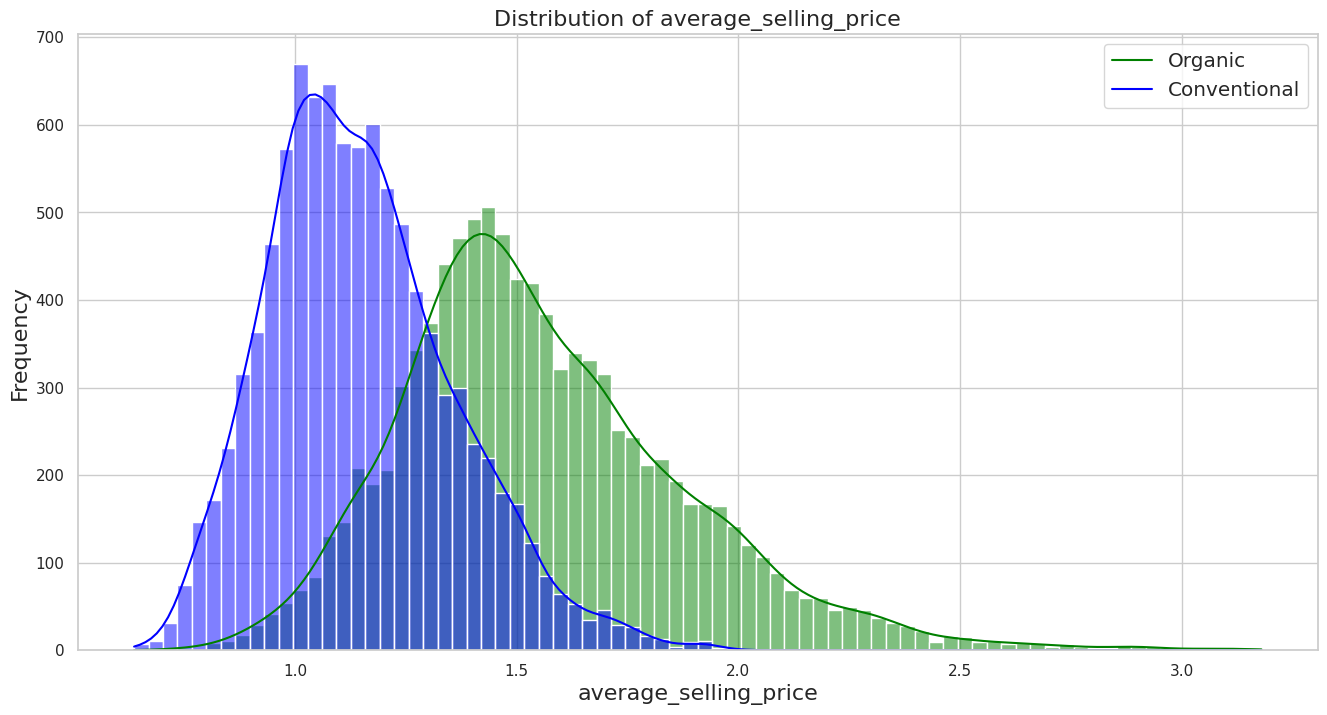

In [99]:
col = "average_selling_price"
plt.figure(figsize=(16,8))
sns.histplot(df, x=col, hue="type", kde=True,  palette={'Conventional': 'blue', 'Organic': 'green'})
plt.title(f"Distribution of {col}", fontsize=16)
plt.xlabel(f"{col}", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.legend(["Organic", "Conventional"], fontsize="large")

plt.show()


### Observations
* Price looks normally distributd
* Organic avocados tend to be more expensive than conventional avocados

### Production volumes and economic indicator distributions

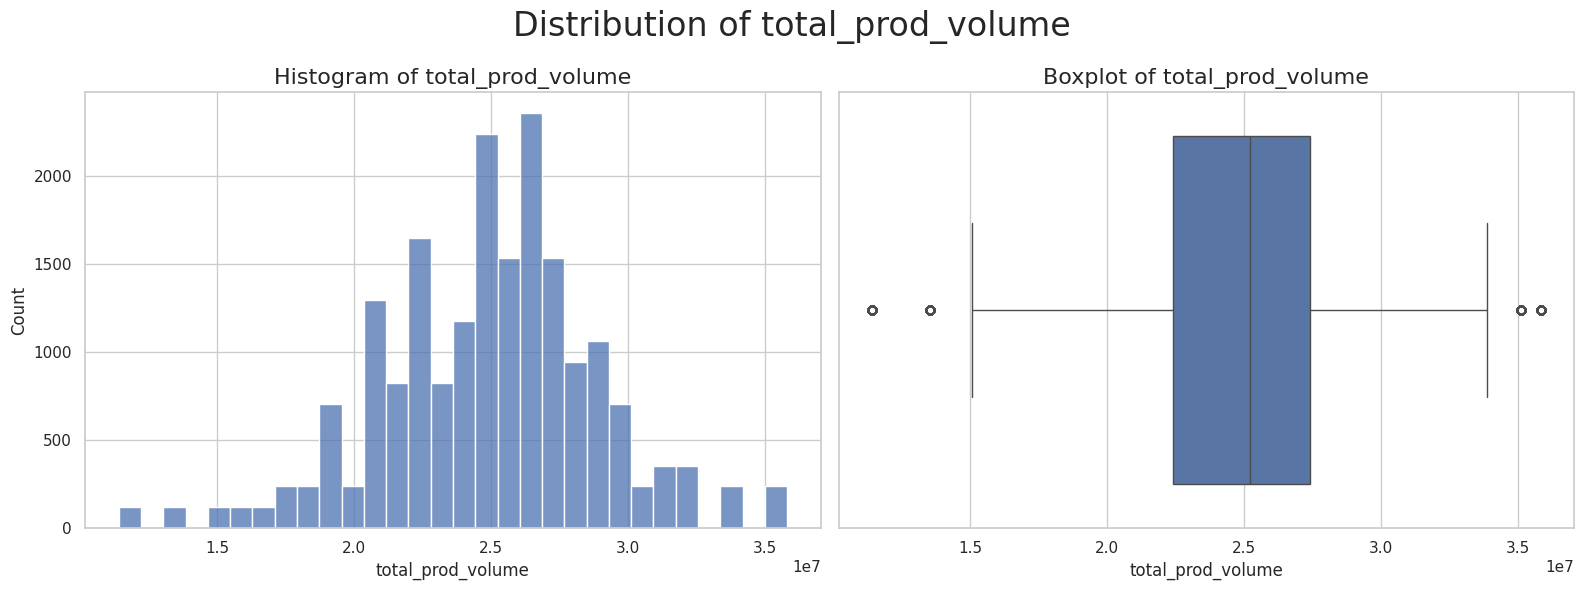

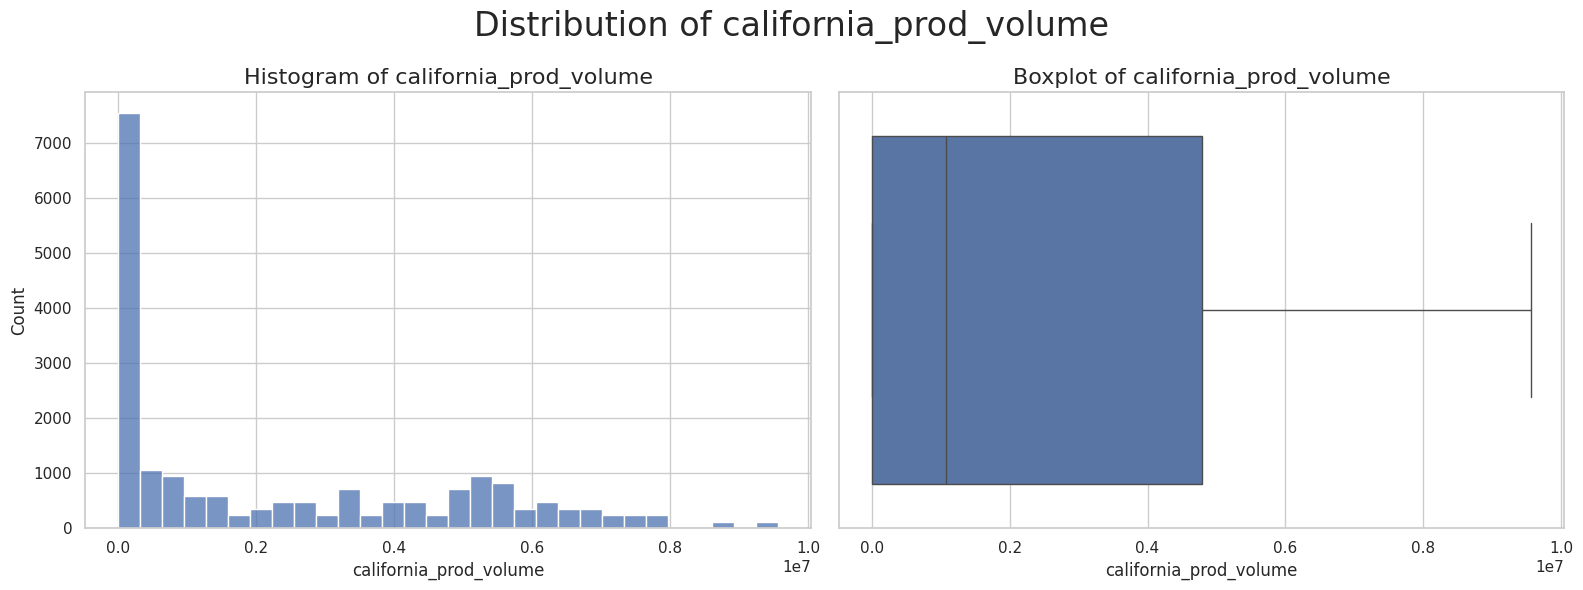

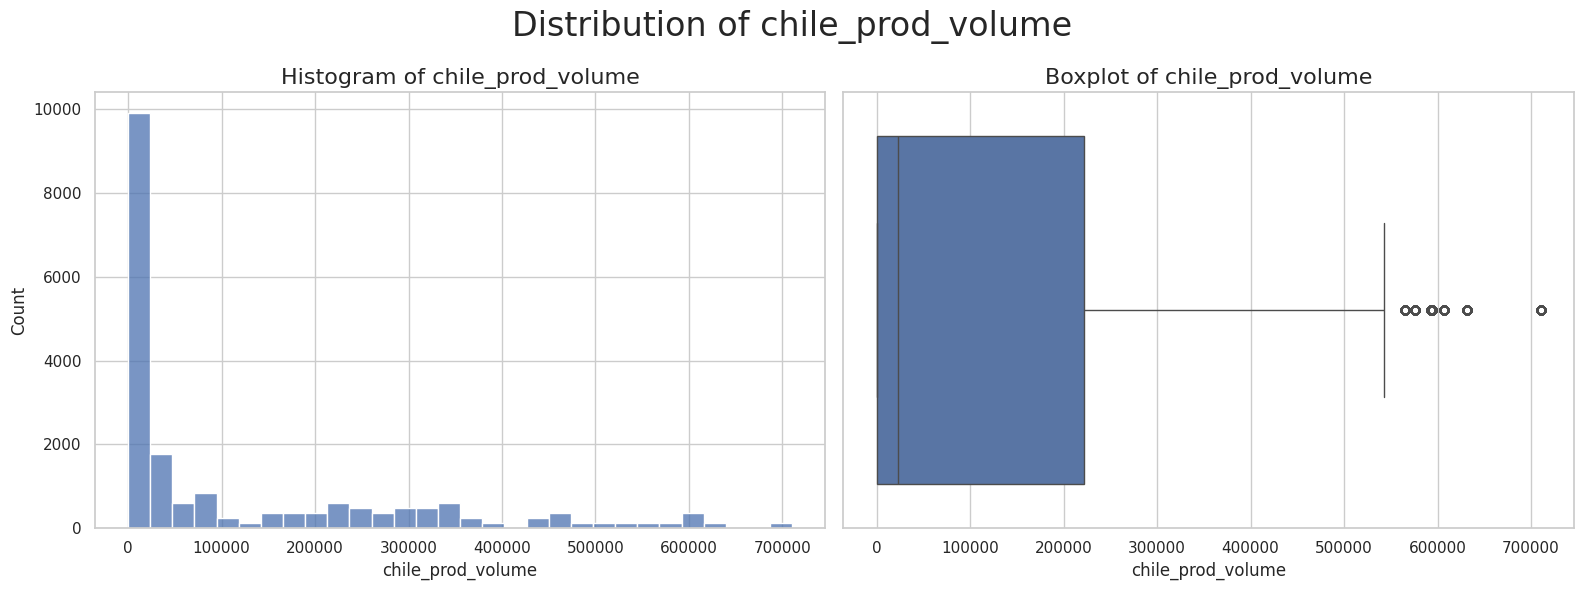

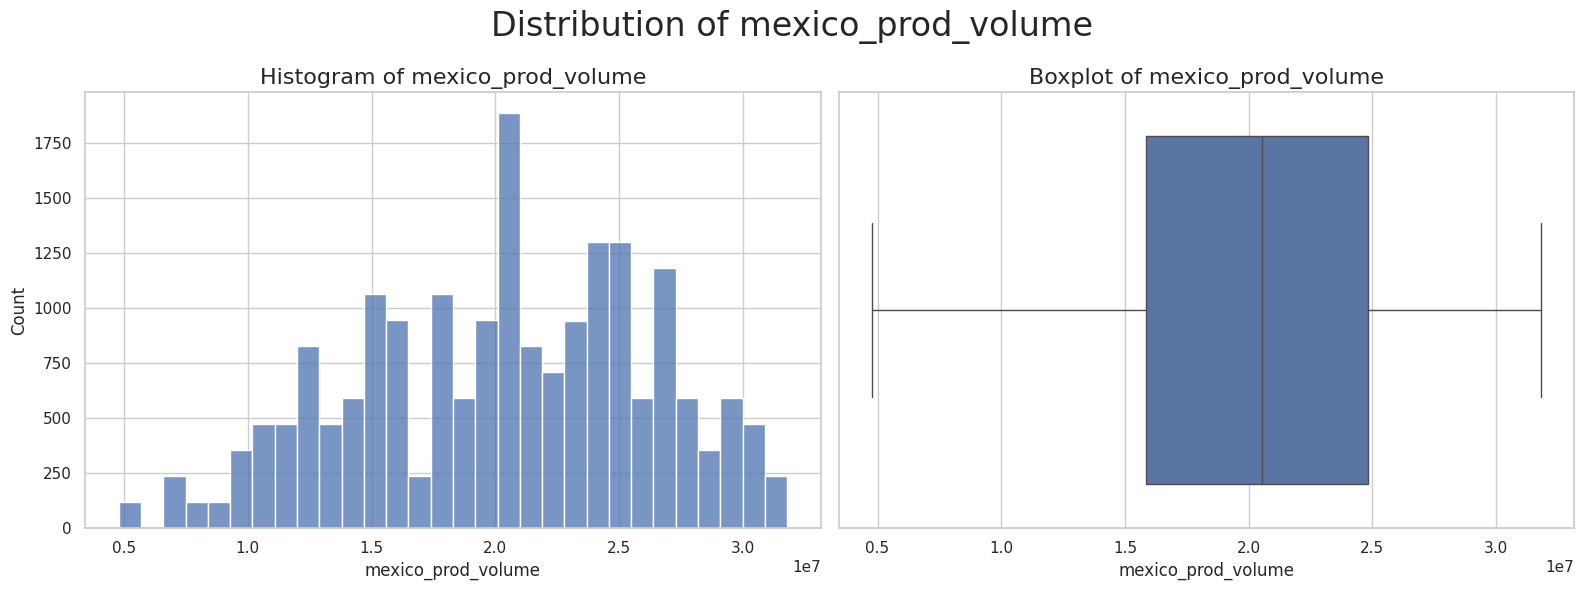

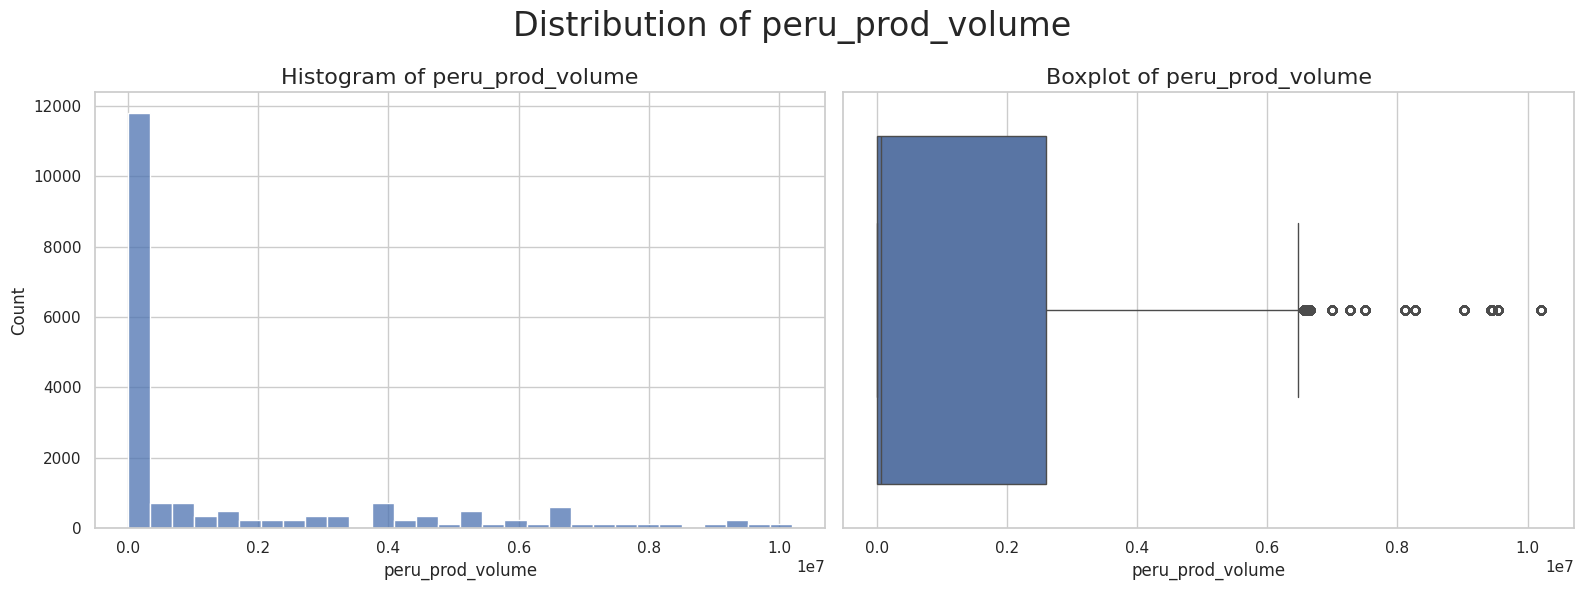

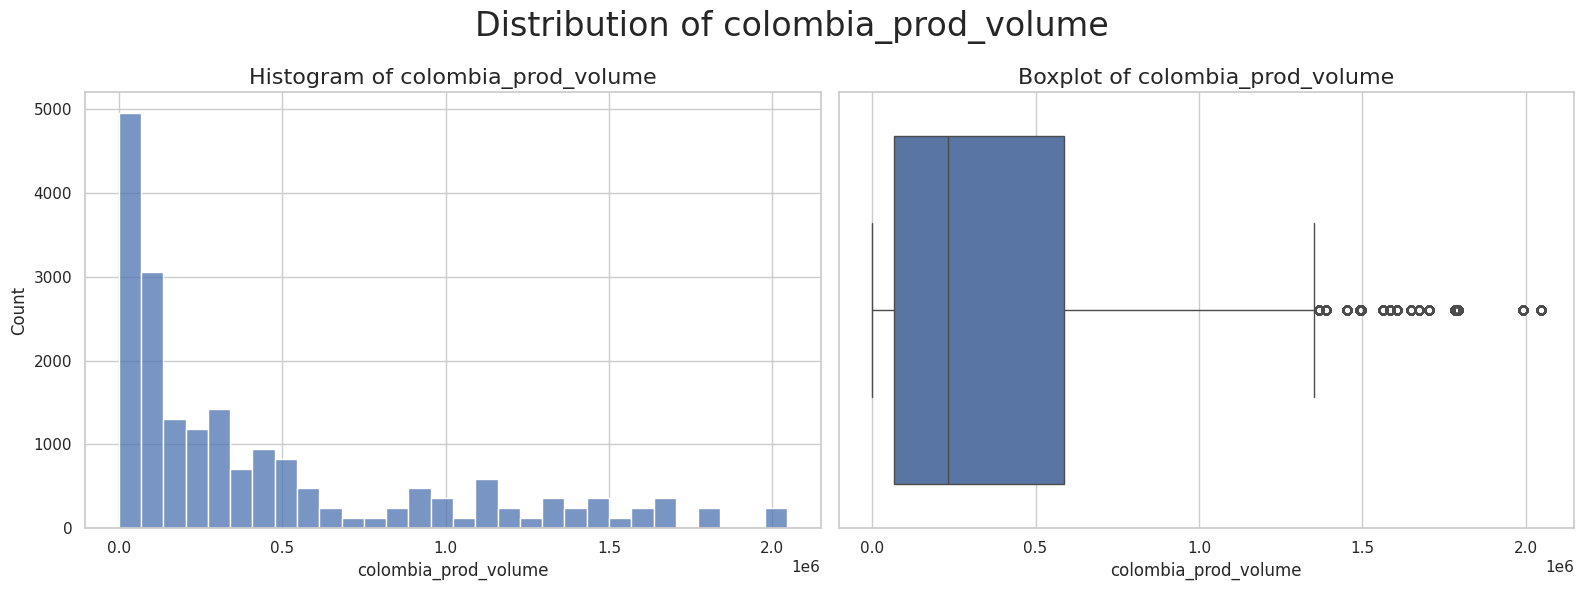

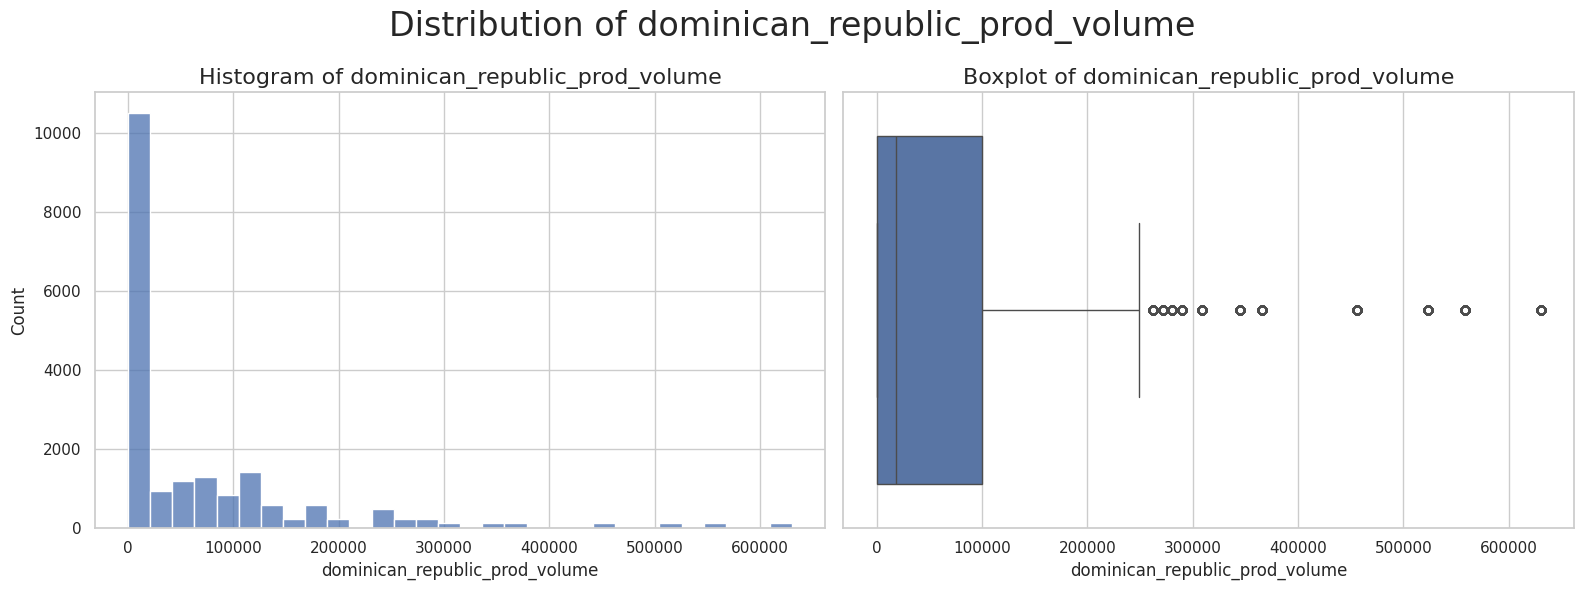

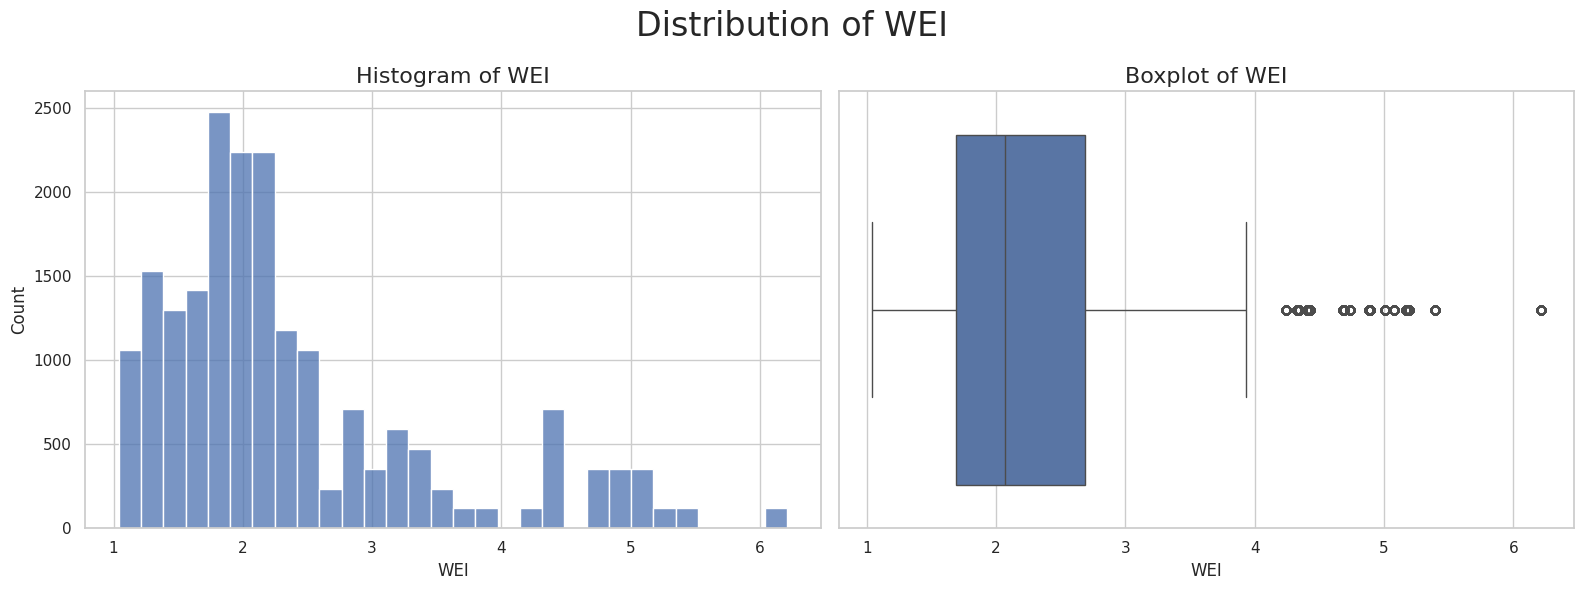

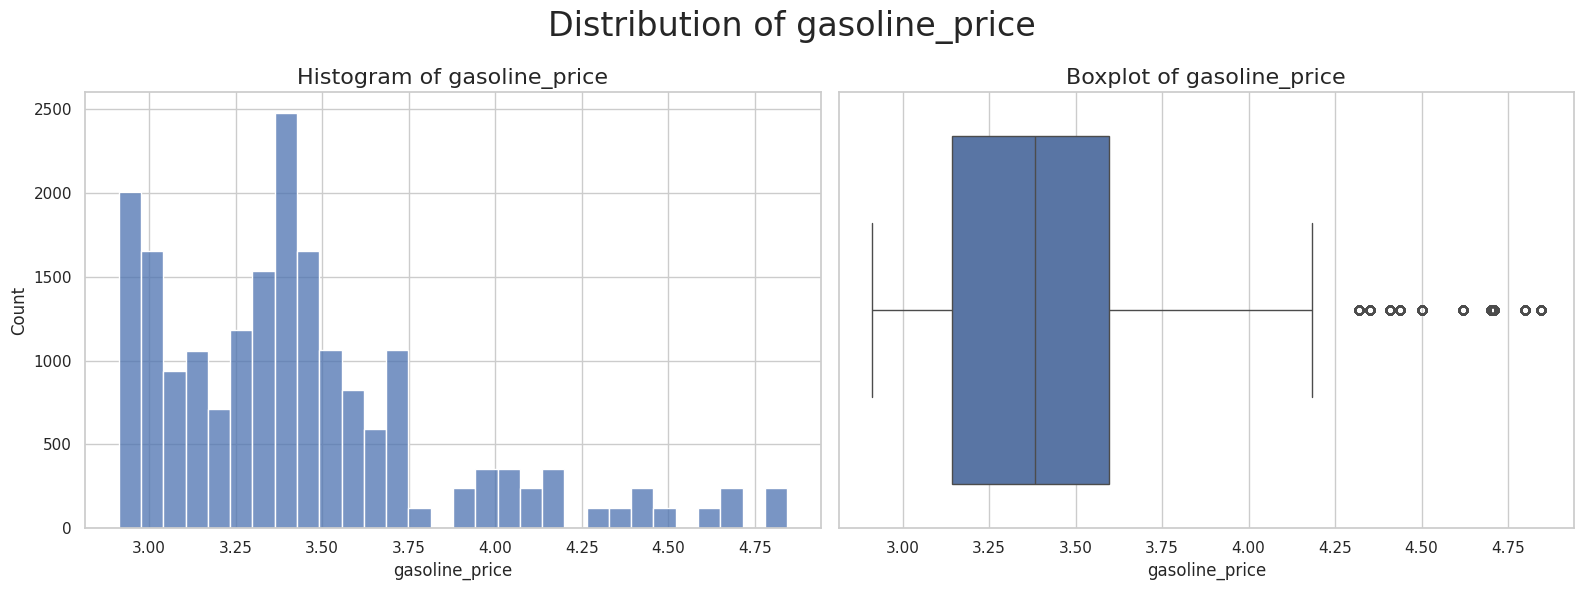

In [100]:
prod_volume_and_ecomomic_factors = ['total_prod_volume', 'california_prod_volume',
            'chile_prod_volume', 'mexico_prod_volume', 'peru_prod_volume',
            'colombia_prod_volume', 'dominican_republic_prod_volume', 'WEI',
            'gasoline_price']

for col in prod_volume_and_ecomomic_factors:

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16,6))

    ax1 = sns.histplot(x=df[col], bins=30, ax=ax1)
    ax1.set_title(f'Histogram of {col}', size=16)

    ax2 = sns.boxplot(x=df[col], ax=ax2)
    ax2.set_title(f'Boxplot of {col}', size=16)

    plt.suptitle(f'Distribution of {col}', size=24)

    plt.tight_layout()

### Observations
* Except for total production volume and Mexico's production volume, the other volume distributions are right-skewed, as most regions can only grow avocados during specific times of the year.
* Mexico seems to be able to produce avocados all year round.
* Ouliers are present in most of the variables

## Avocado price trend vs sales volume trend

In [101]:
def plot_trend(df, x, y):
  df['date'] = pd.to_datetime(df['date'])
  df_price = df.groupby('date')[x].mean().reset_index()

  plt.figure(figsize=(14, 6))

  ax1 = sns.lineplot(x='date', y=x, data=df_price, color='green', label=x)

  df_volume = df.groupby('date')[y].sum().reset_index()

  ax2 = ax1.twinx()
  sns.lineplot(x='date', y=y, data=df_volume, ax=ax2, color='orange', label=y)

  ax1.set_title(f"{x} and {y} Trend Over Time")

  lines1, labels1 = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
  ax2.legend_ = None
  plt.show()

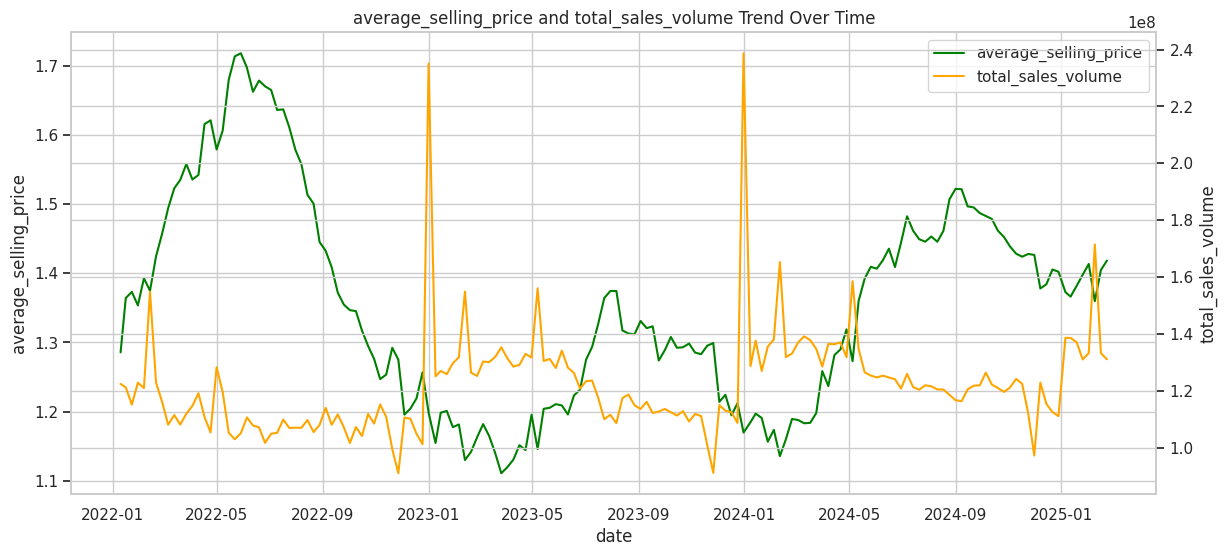

In [102]:
plot_trend(df, "average_selling_price", "total_sales_volume")

### Observations

* Avocado prices have fluctuated over the years, making it challenging for price prediction models to identify a clear pattern.
* Spikes in sales volume often correspond with dips in price.

## Avocado price trend vs total production volume trend

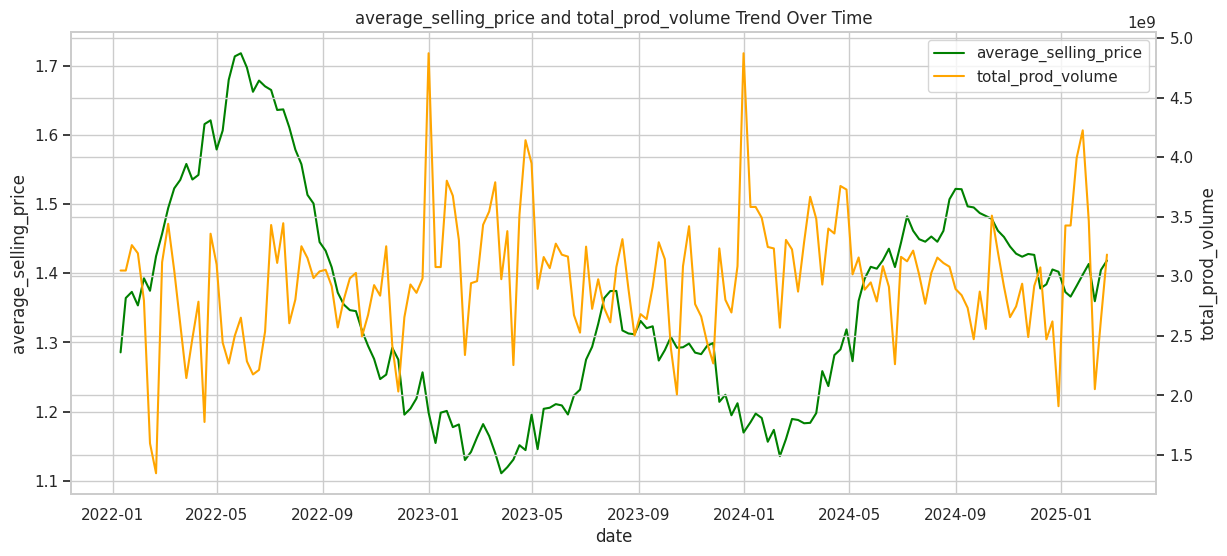

In [103]:
plot_trend(df, "average_selling_price", "total_prod_volume")

### Observations
* Total production volume also negatively correlates with the price, volume goes up, price goes down.

## Correlation matrix between numerical variables

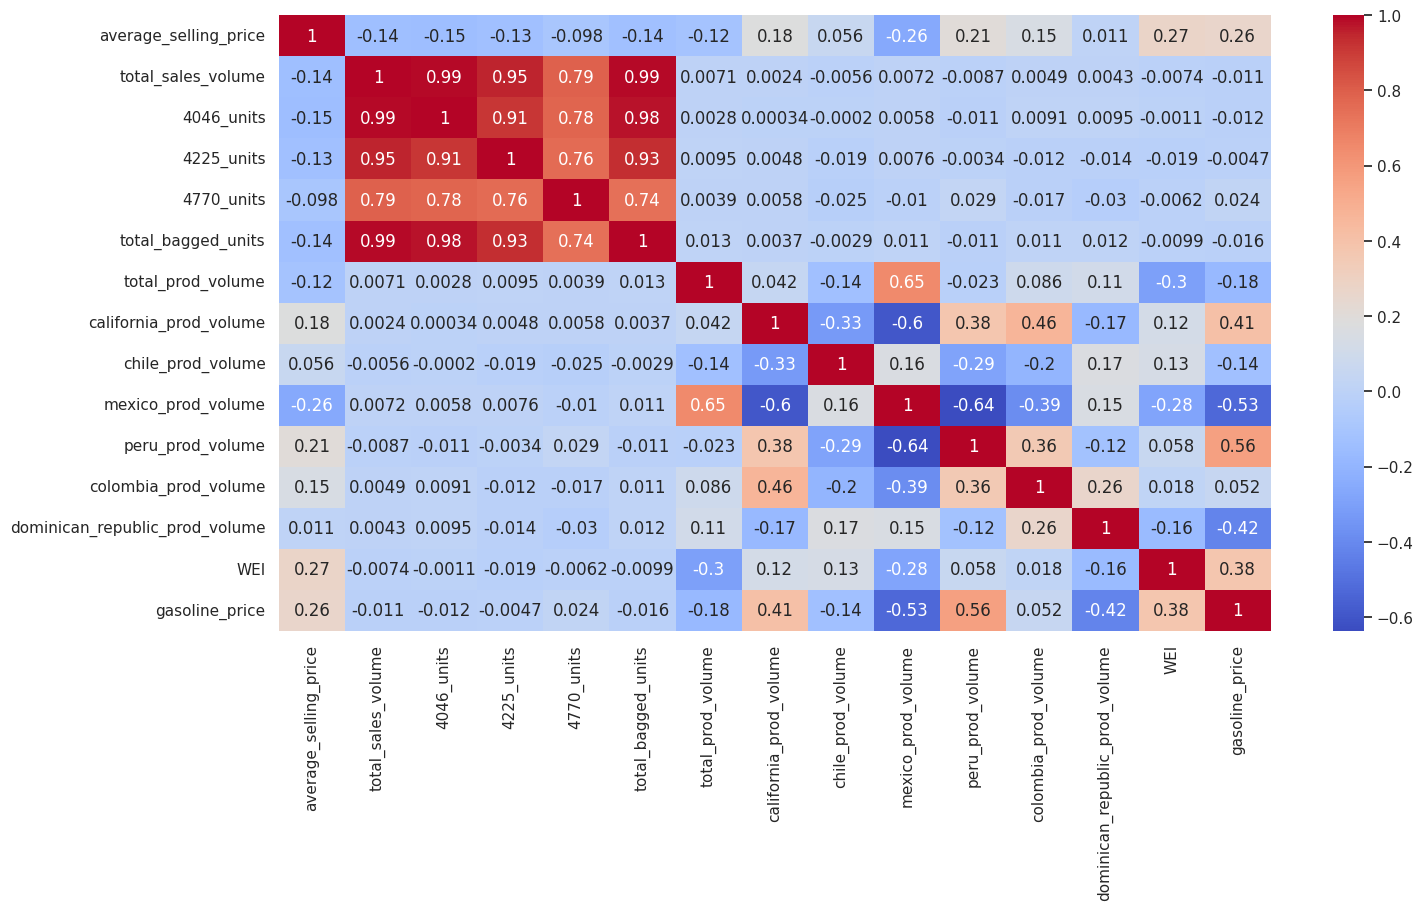

In [104]:
plt.figure(figsize=(16, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

### Observations

* Sales volume columns are highly correlated with one another, we should only keep one of them to avoid multicollinearity.
* The weekly economic indicator and gas price variables show a positive correlation with the price, though the strength of the relationship is moderate(0.26 and 0.27 respectively).
* While the production volumes of other countries show positive correlations with price, Mexico's production volume negatively correlates with the average price, primarily because 90% of U.S. avocado imports come from Mexico.
* Total production volume and Mexico's production volume exhibit a moderate positive correlation, indicating redundancy. To avoid multicollinearity, we should retain only one of them.

## Correlation matrix after removing correlated independent variables

In [105]:
columns_to_remove = ["4046_units", "4225_units", "4770_units", "total_bagged_units", "total_prod_volume", "chile_prod_volume", "dominican_republic_prod_volume"]
for column in columns_to_remove:
    num_cols.remove(column)
df.drop(columns=columns_to_remove, inplace=True)

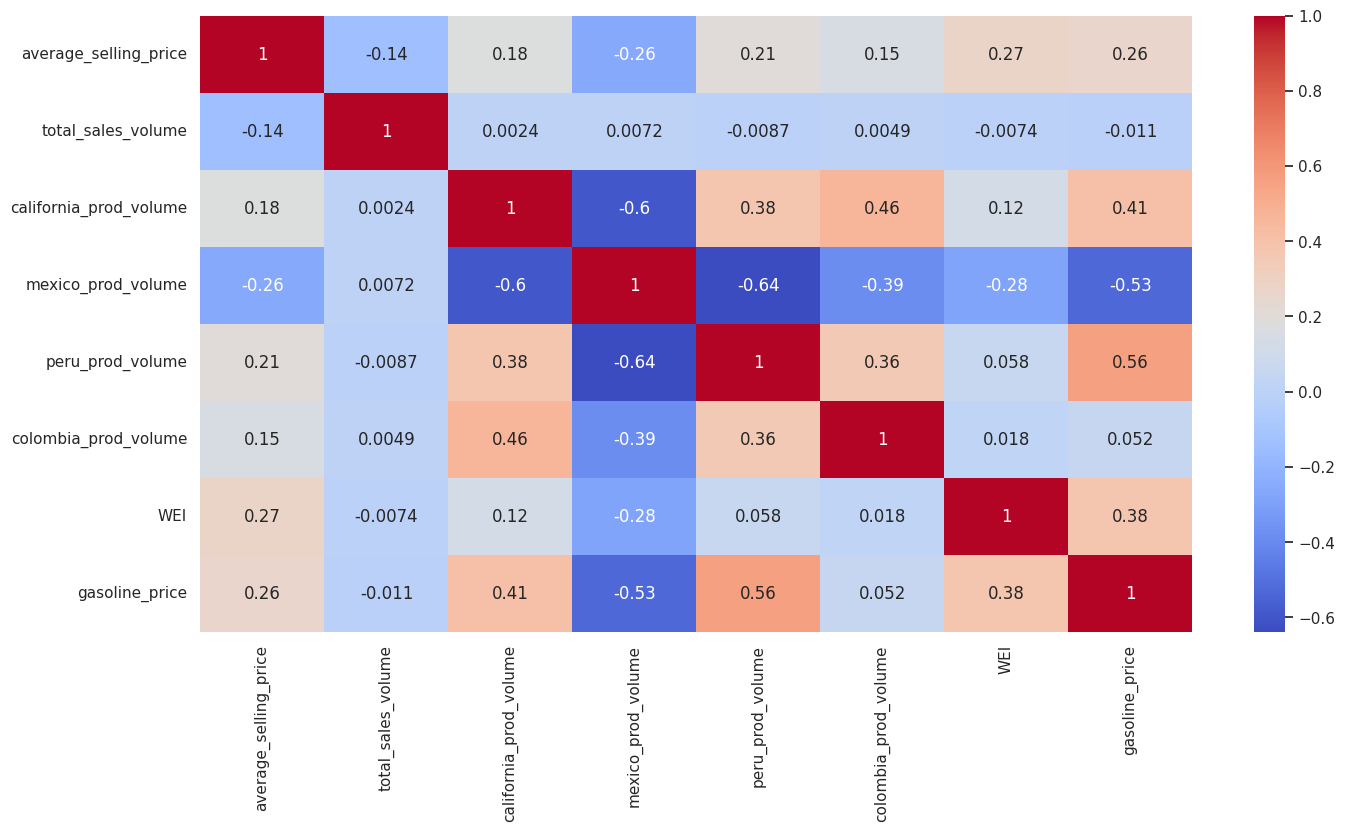

In [106]:
plt.figure(figsize=(16, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

## Correlation between categorical variables and the price

### type vs price

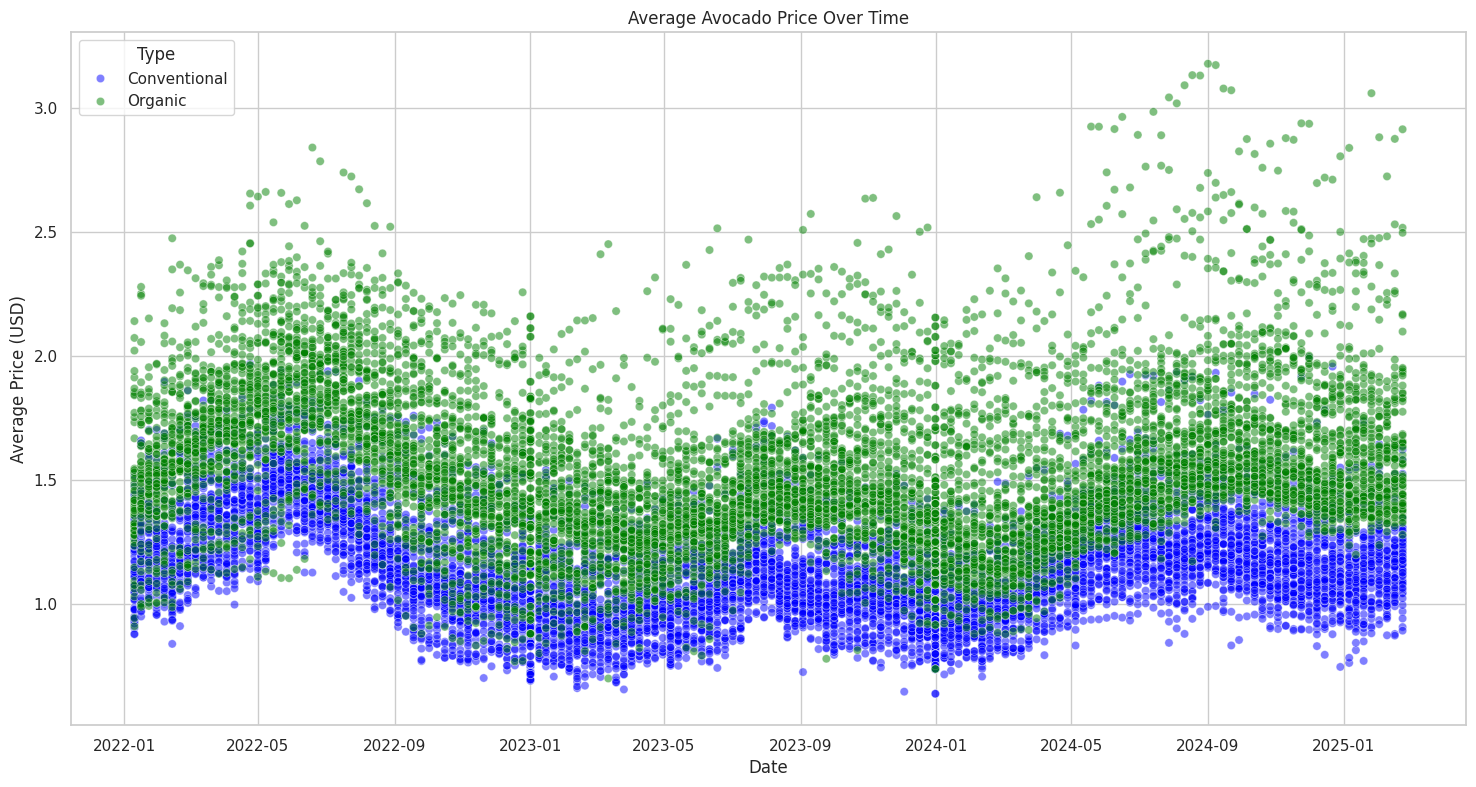

In [107]:
sns.set(style='whitegrid')

plt.figure(figsize=(18, 9))
sns.scatterplot(data=df, x='date', y='average_selling_price', hue='type', alpha=0.5, palette={'Conventional': 'blue', 'Organic': 'green'})

plt.xlabel('Date')
plt.ylabel('Average Price (USD)')
plt.title('Average Avocado Price Over Time')
plt.legend(title='Type')
plt.show()

### Observations
It's clear from the chart that organic avocados tend to be more expensive and type is potentially a good preditor.

### is_holiday vs price

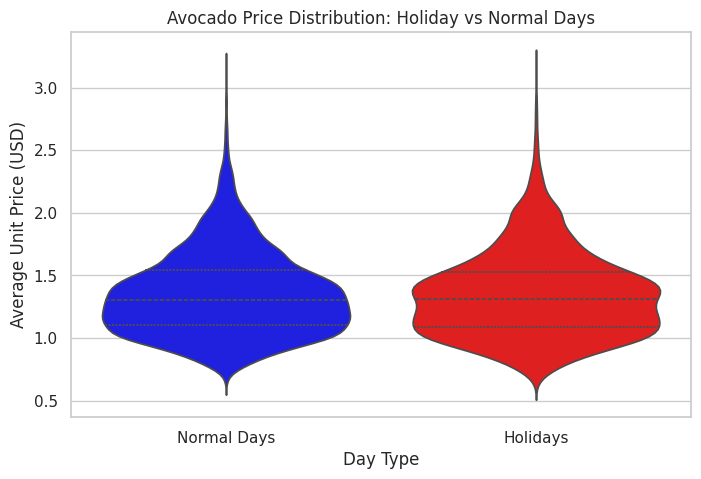

In [108]:
plt.figure(figsize=(8, 5))
sns.violinplot(x=df['is_holiday'], y=df['average_selling_price'], palette=['blue', 'red'], inner='quartile', hue=df['is_holiday'], legend=False)

plt.xticks([0, 1], ['Normal Days', 'Holidays'])
plt.xlabel("Day Type")
plt.ylabel("Average Unit Price (USD)")
plt.title("Avocado Price Distribution: Holiday vs Normal Days")

plt.show()


### Observations
The price distribution during holidays and normal days appears similar, indicating that is_holiday is not a strong predictor of price fluctuations.

In [109]:
df.drop(columns=["is_holiday"], inplace=True)

### Montly average price

In [110]:
df["month"] = df["date"].dt.month

In [111]:
monthly_prices = df.groupby("month")["average_selling_price"].mean()

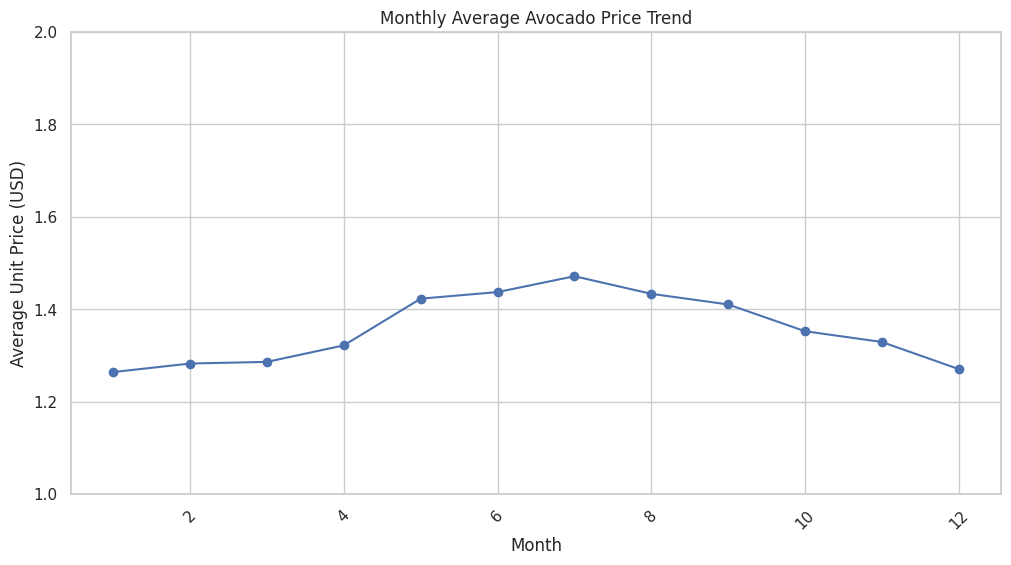

In [112]:
plt.figure(figsize=(12, 6))
monthly_prices.plot(marker="o", linestyle="-", color="b")

plt.title("Monthly Average Avocado Price Trend")
plt.xlabel("Month")
plt.ylabel("Average Unit Price (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.ylim(1, 2)
plt.show()

### Observations
People tends to buy more avocados in the summer months, which drives the price up during this time. Month can be a good predictor.

# Data processing

## Check for null and duplicate values

In [113]:
df.isnull().sum()

region                    0
date                      0
type                      0
average_selling_price     0
total_sales_volume        0
year_week                 0
california_prod_volume    0
mexico_prod_volume        0
peru_prod_volume          0
colombia_prod_volume      0
WEI                       0
gasoline_price            0
month                     0
dtype: int64

In [114]:
print(f"Total duplicate rows: {df.duplicated().sum()}")

Total duplicate rows: 236


In [115]:
df.drop_duplicates(inplace=True)

In [116]:
print(f"Total duplicate rows: {df.duplicated().sum()}")

Total duplicate rows: 0


## Remove outliers

In [117]:
original_length = len(df)

In [118]:
def remove_outliers(df, column):

    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr

    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df
cols = [
    'california_prod_volume',
    'mexico_prod_volume',
    'peru_prod_volume',
    'colombia_prod_volume',
    'WEI',
    'gasoline_price'
    ]
for col in cols:
  if col != 'price':
    df = remove_outliers(df, col)

In [119]:
print(f"Number of rows removed: {original_length - len(df)}")

Number of rows removed: 118


## Encode categorical variables

In [120]:
df = df.dropna().reset_index(drop=True)
categorical_df = pd.get_dummies(df[['type','region']], drop_first = True)

In [121]:
df = pd.concat([df, categorical_df], axis=1)

## Scale numerical variables

In [122]:
scaled_cols = [col for col in num_cols if col != 'average_selling_price']
scaler = StandardScaler()
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

## Split data into train and test sets

In [123]:
def split_by_region(df, target, test_size=0.2):
    train_list = []
    test_list = []

    for region, region_df in df.groupby("region"):
        region_df = region_df.sort_values("date")
        X = region_df.loc[:, df.columns != target]
        y = region_df[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

        train_list.append(pd.concat([X_train, y_train], axis=1))
        test_list.append(pd.concat([X_test, y_test], axis=1))

    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)

    return train_df, test_df

In [124]:
target = "next_week_average_selling_price"

In [125]:
df.sort_values(["region", "type", "date"], inplace=True)

In [126]:
df[target] = df.groupby(["region", "type"])["average_selling_price"].shift(-1)

In [127]:
df.dropna(inplace=True)

In [128]:
train_df, test_df = split_by_region(df, target)

In [129]:
train_df.drop(columns=['date', 'region', 'type', 'year_week'], inplace=True)

In [130]:
features = [col for col in train_df.columns if col not in [
    target,
    # "average_selling_price",
    # 'total_sales_volume',
    # 'california_prod_volume',
    # 'mexico_prod_volume',
    # 'chile_prod_volume',
    # 'peru_prod_volume',
    # 'colombia_prod_volume',
    # 'dominican_republic_prod_volume',
    # 'WEI',
    # 'gasoline_price',
    # 'is_holiday',
    ]]

In [131]:
X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

## Train regression models

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

results = {
    'Model': [],
    'MAE': [],
    'RMSE': [],
    'R^2': []
}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    predictions[name] = y_pred
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results['Model'].append(name)
    results['MAE'].append(mae)
    results['RMSE'].append(rmse)
    results['R^2'].append(r2)

    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R^2: {r2:.2f}")

results_df = pd.DataFrame(results)


Linear Regression - MAE: 0.06, RMSE: 0.09, R^2: 0.94


## Evaluate regression models

In [ ]:
metrics = ["MAE", "RMSE", "R^2"]
models = results["Model"]
values = results_df[metrics].values.T

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors = ['blue', 'green', 'red']

for i, metric in enumerate(metrics):
    bars = axes[i].bar(models, results_df[metric], color=colors)

    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}",
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

    axes[i].set_title(metric)
    axes[i].set_ylabel("Value")
    axes[i].xaxis.set_ticks(models)
    axes[i].set_xticklabels(models, rotation=20)
    axes[i].grid(axis='y', linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


### Observations
It appears that Linear Regression perform best in all metrics. More specifically, it has the lowest Mean Absolute Error, lowest Root Mean Squared Error and highest R squared. While Random Forest is a strong alternative as its metrics are close to Linear Regression, XGBoost slightly underpeforms.

## Plot actual vs predicted prices

In [ ]:
best_model = "Linear Regression"

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_df['date'], y=y_test, label='Actual', color='blue')
sns.lineplot(x=test_df['date'], y=predictions[best_model], label=f'Predicted ({best_model})', color='red')
plt.xlabel('Date')
plt.ylabel('Average Price (USD)')
plt.title('Actual vs Predicted Avocado Prices')
plt.legend()
plt.grid(True)
plt.show()